In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

First, let's load and view our images.

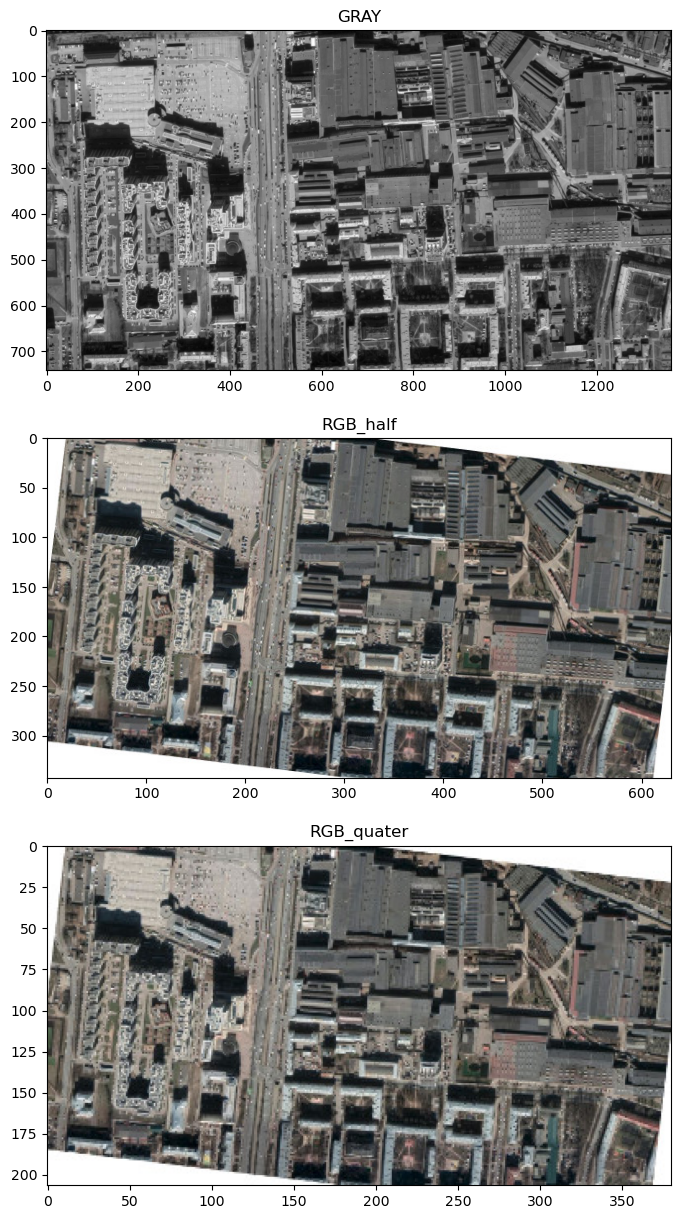

In [67]:
file_path1 = 'GRAY.JPG'
file_path2 = 'RGB_half.JPG'
file_path3 = 'RGB_quater.JPG'
gray = cv2.imread(file_path1, cv2.IMREAD_GRAYSCALE)
bgr_half = cv2.imread(file_path2)
bgr_quater = cv2.imread(file_path3)

rgb_half = cv2.cvtColor(bgr_half, cv2.COLOR_BGR2RGB)
rgb_quater = cv2.cvtColor(bgr_quater, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,15))
plt.subplot(311),plt.imshow(gray,'gray'),plt.title('GRAY')
plt.subplot(312),plt.imshow(rgb_half),plt.title('RGB_half')
plt.subplot(313),plt.imshow(rgb_quater),plt.title('RGB_quater')
plt.show()
#plt.imshow(gray,'gray')
#cv2.waitKey(0) 
#cv2.destroyAllWindows() 

Now we will create a function aimed to align rotated bgr images with the gray one. It uses ORB (Oriented FAST and Rotated BRIEF). It is a fusion of two algorithms:
<br>
- FAST - keypoint detection
<br>
 - BRIEF - descriptor

In order to overcome the issue of FAST algorithm not detecting orientation, it computes the intensity weighted centroid of the patch with located corner at center. The direction of the vector from this corner point to centroid gives the orientation. Then it uses this orientation to rotate keypoints for the BRIEF algorithm.

After detecting the features of images it utilizes Brute-Force matcher between the descriptors of images. Matched keypoints are then used to find the homography and finally we rotate the target image.

Estimated rotation angle: -6.875474467653472
Estimated rotation angle: -6.560750719889967


(<Axes: title={'center': 'RGB_QUATER'}>,
 Text(0.5, 1.0, 'RGB_QUATER'))

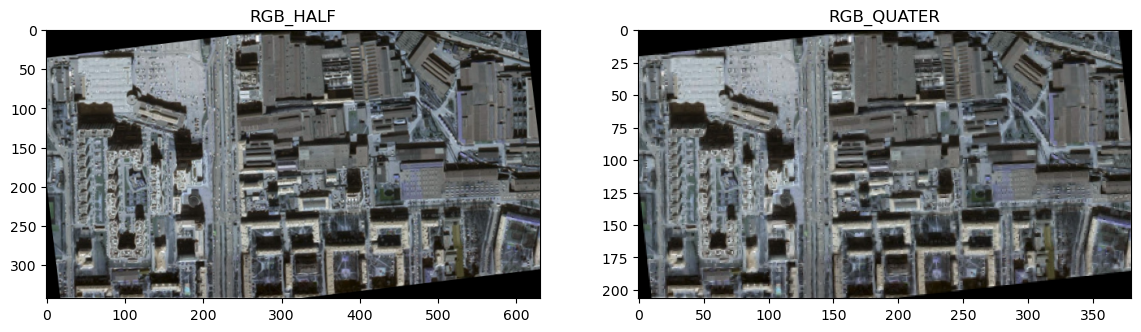

In [68]:
def rotate(bgr, gray):
    orb = cv2.ORB_create()

    bgr_gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    keypoints1, descriptors1 = orb.detectAndCompute(gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(bgr_gray, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract matched keypoints
    matched_keypoints1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    matched_keypoints2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Estimate homography
    H, _ = cv2.findHomography(matched_keypoints1, matched_keypoints2, cv2.RANSAC)

    # Extract rotation angle from homography matrix
    angle_rad = np.arctan2(H[0, 1], H[0, 0])
    angle_deg = np.degrees(angle_rad)

    print("Estimated rotation angle:", angle_deg)

    height, width = bgr.shape[:2]

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), -angle_deg, 1)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(bgr, rotation_matrix, (width, height))
    return rotated_image

rotated_half = rotate(bgr_half, gray)
rotated_quater = rotate(bgr_quater, gray)
plt.figure(figsize=(14,10))
plt.subplot(1,2,1),plt.imshow(rotated_half),plt.title('RGB_HALF')
plt.subplot(1,2,2),plt.imshow(rotated_quater),plt.title('RGB_QUATER')

By looking at the street in the middle of the images we can see that they have been succesfully aligned to the gray image orientation.

Next we resize the bgr images to match the resolution of grayscale one.

(<Axes: >, <matplotlib.image.AxesImage at 0x1f4f6f94d90>)

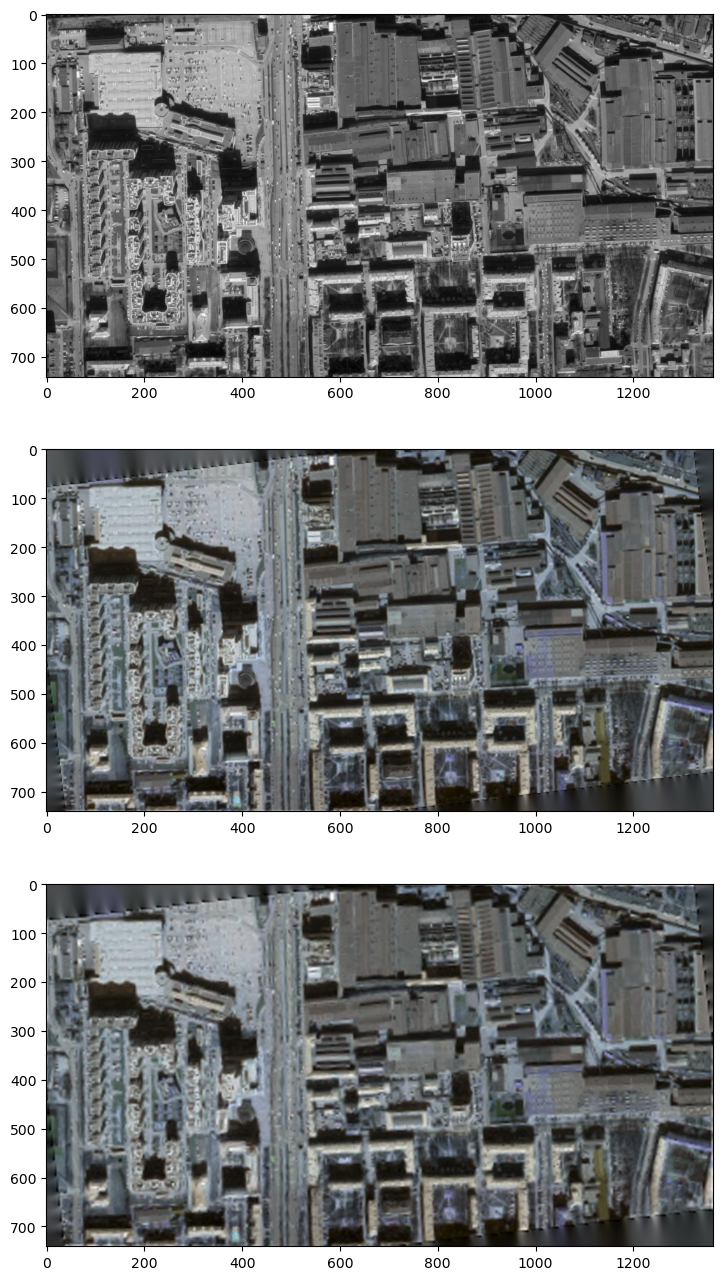

In [69]:
def resize(bgr, gray):
    mask = cv2.inRange(bgr, (0, 0, 0), (0, 0, 0))
    inpainted_image = cv2.inpaint(bgr, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)  

    bgr_high_res = cv2.resize(inpainted_image, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_CUBIC)
    return bgr_high_res

resized_half = resize(rotated_half, gray)
resized_quater = resize(rotated_quater, gray)

plt.figure(figsize=(14,16))
plt.subplot(3,1,1), plt.imshow(gray,'gray')
plt.subplot(3,1,2), plt.imshow(resized_half)
plt.subplot(3,1,3), plt.imshow(resized_quater)

Finally, we will use Brovey sharpening method for panchromatic-sharpening - produce multiband, high resolution image from panchromatic high-resolution fusion with multiband low-resolution. The formula is simple - for each of the color channels we apply:
    $$Color_{out} = \frac{k * Color_{in} * Pan}{Blue_{in} + Green_{in} + Red_{in} }$$
,where Pan is the intensity of pixel in grayscale image and k is a factor that helps improve visual quality (we will use k=3).

(<Axes: title={'center': 'sharpened with quater-resolution'}>,
 Text(0.5, 1.0, 'sharpened with quater-resolution'))

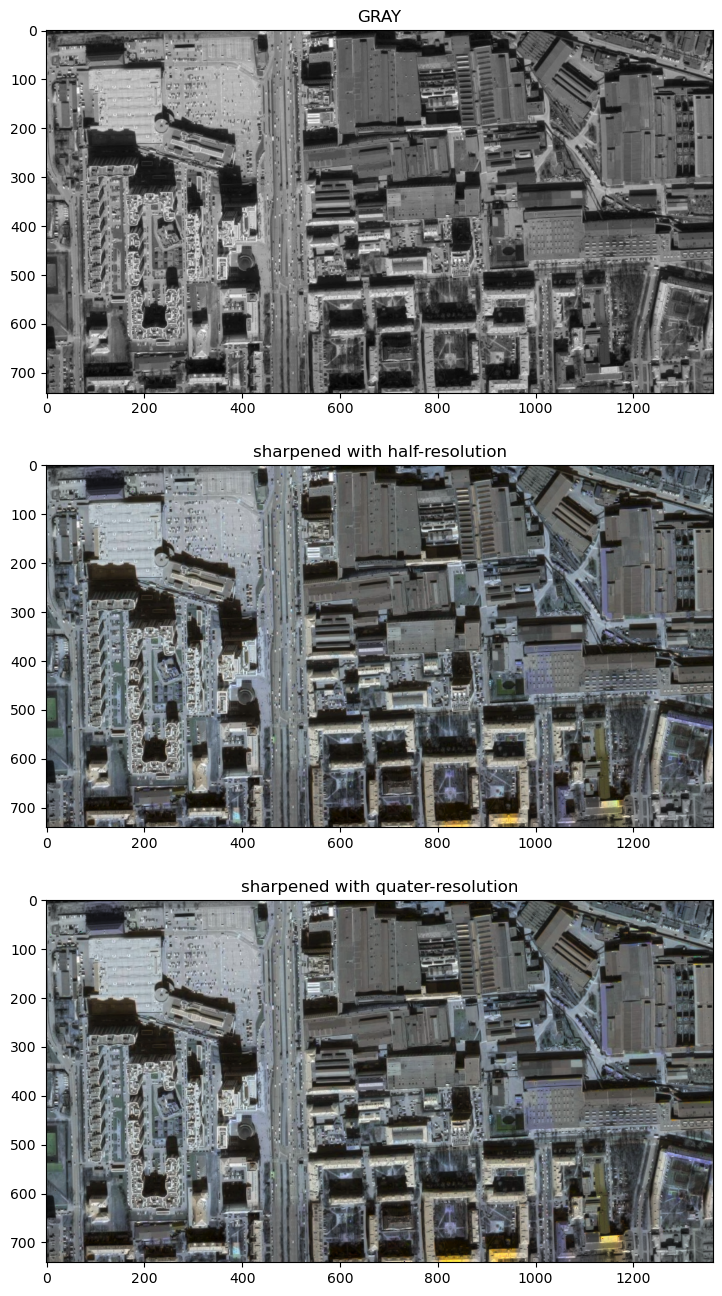

In [70]:
def brovey_sharpening(bgr, gray):

    bgr = bgr.astype(np.float32)
    gray = gray.astype(np.float32)
    
    #gray_normalized = gray / 255.0
    
    blue, green, red = cv2.split(bgr)

    eps = 1e-5

    sharpened_blue = 3 * blue * (gray / (blue + green + red + eps))
    sharpened_green = 3 * green * (gray / (blue + green + red + eps))
    sharpened_red = 3 * red * (gray / (blue + green + red + eps))
    
    sharpened_blue = np.clip(sharpened_blue, 0, 255).astype(np.uint8)
    sharpened_green = np.clip(sharpened_green, 0, 255).astype(np.uint8)
    sharpened_red = np.clip(sharpened_red, 0, 255).astype(np.uint8)
    
    sharpened_bgr_image = cv2.merge((sharpened_blue, sharpened_green, sharpened_red))
    
    return sharpened_bgr_image


sharpened_half = brovey_sharpening(resized_half, gray)
sharpened_quater = brovey_sharpening(resized_quater, gray)

#plt.imshow(rotated_image)
plt.figure(figsize=(14,16))
plt.subplot(3,1,1), plt.imshow(gray,'gray'), plt.title('GRAY')
plt.subplot(3,1,2), plt.imshow(sharpened_half), plt.title('sharpened with half-resolution')
plt.subplot(3,1,3), plt.imshow(sharpened_quater), plt.title('sharpened with quater-resolution')


We obtained sharpened images from the half- and quater-resolution images. The final effect is very simmilar between both images. Differences are seen only in small details - the higher resolution image probably allowed to recreate them more accurately.